In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm

In [3]:
def typecheck(l: dict):
    # Typecheck loaded stuff (prevents weird errors lower down if wrong)
    # TODO: Use validation lib (nicer errors)
    assert type(l["level_seed"]) == int
    assert isinstance(l["actions"], list)
    assert isinstance(l["rewards"], list)
    assert all(type(a) == int for a in l["actions"])
    assert all(type(r) == float for r in l["rewards"])

In [4]:
def load_run(file: str):
    with open(file, 'rb') as f:
        run = pickle.load(f)

    typecheck(run)

    venv = ProcgenGym3Env(
        num=1, env_name='maze', num_levels=1, start_level=run["level_seed"],
        distribution_mode='hard', render_mode='rgb_array'
    )
    venv = maze.wrap_venv(venv)
    assert run["level_seed"] == venv.env.get_info()[0]["level_seed"], 'level seed doesnt match created env'

    state_bytes = venv.env.callmethod("get_state")[0]
    state_vals = maze.parse_maze_state_bytes(state_bytes)
    grid = maze.get_grid(state_vals)
    run["grid"] = grid
    run["mouse_positions"] = [maze.get_mouse_pos(state_vals)]
    run["start_info"] = venv.env.get_info()[0]

    obs = venv.reset()
    for (i, act) in enumerate(run["actions"]):
        obs, rew, done, info = venv.step(np.array([act]))
        assert rew == run["rewards"][i], f"got reward {rew} doesn't match {run['rewards'][i]}"
        state_vals = maze.parse_maze_state_bytes(venv.env.callmethod("get_state")[0])
        if done:
            break
        run["mouse_positions"].append(maze.get_mouse_pos(state_vals))
        # run["positions"].append(info["position"])

    # DO NOT return venv. after stepping through it, we could be on a different level
    return run

  0%|          | 0/100 [00:00<?, ?it/s]

building procgen...done


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


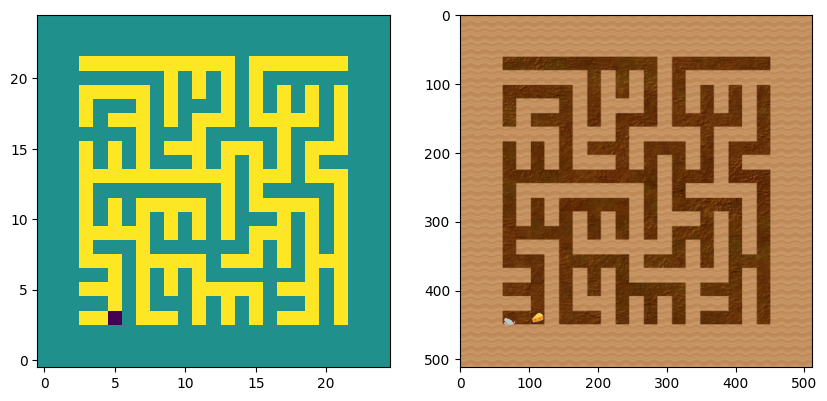

In [5]:
files = glob('data/model*ep*.pkl')
runs = [load_run(f) for f in tqdm(files[:100])]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(runs[0]["grid"], origin='lower')
ax[1].imshow(runs[0]["start_info"]["rgb"])
plt.show()


In [6]:
runs[0]["mouse_positions"]

[(3, 3), (3, 4), (3, 4)]

## Replay a run

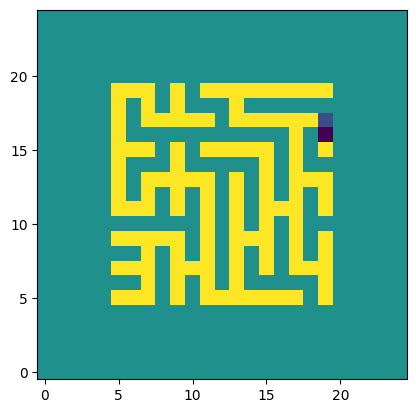

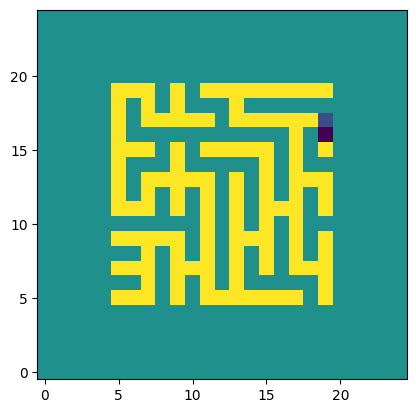

In [7]:
r = runs[1]
for t in range(0, len(r["mouse_positions"])):
    grid = r["grid"].copy()
    mx, my = r["mouse_positions"][t]
    grid[mx, my] = maze.MOUSE
    
    plt.imshow(grid, origin='lower')
    display.clear_output(wait=True)
    display.display(plt.gcf())

## Plot distance(mouse, cheese)

In [8]:
for r in runs:
    cx, cy = maze.get_cheese_pos(r['grid'])
    mx, my = r["mouse_positions"][-1]
    print(np.sqrt((cx-mx)**2 + (cy-my)**2)) # 1 = one step away from cheese (win!)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
4.123105625617661
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
7.810249675906654
1.0
1.0
1.0
20.024984394500787
1.0
1.0
1.0
1.0
3.1622776601683795
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
5.385164807134504
1.0
1.0
1.0
1.0
1.0
1.0
1.0
10.816653826391969
1.0
1.0
1.0
1.0
1.0
5.385164807134504
1.0
1.0
1.0
1.0
8.0
1.0
1.0
1.0
1.0
14.317821063276353
1.0
1.0
1.0
1.0
1.0
7.0710678118654755
1.0
1.0
18.027756377319946
10.816653826391969
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
3.605551275463989
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [11]:
distances = [0] * 257
nums = [0] * 257
for i, r in enumerate(runs):
    cx, cy = maze.get_cheese_pos(r['grid'])
    for t, (x,y) in enumerate(r["mouse_positions"]): # ignore last pos, as it's a new level
        nums[t] += 1
        distances[t] += np.sqrt((cx-x)**2 + (cy-y)**2)


distances = [distances[i] / max(1,nums[i]) for i in range(len(distances))]

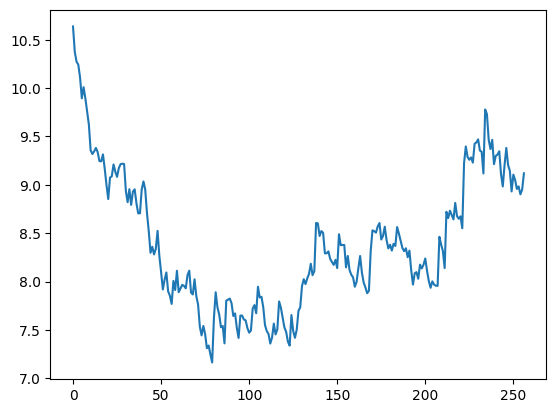

In [12]:
plt.plot(distances)
plt.show()

**Interpretation:** I think the graph is telling us that typically, we either solve the maze relatively quickly, or get stuck and run out of time (rightmost side)

In [20]:
A = [[np.sqrt((maze.get_cheese_pos(r["grid"])[0]-x)**2 + (maze.get_cheese_pos(r["grid"])[1]-y)**2) for (x,y) in r["mouse_positions"]] for r in runs]
